In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from concurrent.futures import ProcessPoolExecutor

In [3]:
# Define the model itself

# Define a structured array type for parameters
param_dtype = np.dtype([
    ('beta0', np.float64),
    ('beta_amp', np.float64),
    ('freq', np.float64),
    ('phase', np.float64),
    ('gamma', np.float64),
    ('waning_rate', np.float64),
    ('birth_rate', np.float64),
    ('death_rate', np.float64),
    ('noise_level', np.float64)
])

@njit
def is_close_to_multiple(number, multiple, tolerance):
  """
  Checks if a number is close to a multiple of another number.

  Args:
    number: The number to check.
    multiple: The multiple to check against.
    tolerance: The allowed deviation from a perfect multiple.

  Returns:
    True if the number is close to a multiple, False otherwise.
  """

  remainder = number % multiple
  return remainder <= tolerance or remainder >= multiple - tolerance

@njit
def run_simulation(t, params, S0, I0, strobe=7):
    
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))
    S[0], I[0], R[0] = S0, I0, 1 - S0 - I0

    dt = t[1]-t[0]
    
    gamma = params.gamma
    mu = params.birth_rate
    delta = params.waning_rate
    noise_level = params.noise_level

    if noise_level > 0:
        alpha = dt/noise_level**2
        beta = noise_level**2
        k_shape = alpha
        theta_scale = beta
    
    for i in range(1,len(t)):
        beta = params.beta0 * (1 + params.beta_amp * np.sin(2 * np.pi * params.freq * t[i] + params.phase))
        if noise_level > 0:
            DeltaGamma_loc = np.random.gamma(k_shape, theta_scale)
            noise = DeltaGamma_loc/dt
        else:
            noise = 1.0
        beta = beta * noise
        foi = beta * I[i-1]
        Sout = (1 - np.exp(-(foi + mu)*dt)) * S[i - 1]
        StoI = foi / (foi + mu) * Sout
        Iout = (1 - np.exp(-(gamma + mu)*dt)) * I[i - 1]
        ItoR = gamma / (gamma + mu) * Iout
        Rout = (1 - np.exp(-(delta + mu)*dt)) * R[i - 1]
        RtoS = Rout * delta/(delta + mu);
        #RtoS = 0
        S[i] = S[i - 1] - Sout + mu*dt + RtoS
        I[i] = I[i - 1] + StoI - Iout
        R[i] = R[i - 1] + ItoR - Rout
    
    return t[::strobe], I[::strobe], S[::strobe]

# Helper functions:
def compute_SIR(t, params, initial_condition, strobe=7):
    (S0, I0) = initial_condition
    t_out, I, S = run_simulation(t, params, S0, I0, strobe=strobe)
    return I, S

# Parallel execution
def parallel_SIRS(initial_conditions):
    out = compute_SIR(t, params, initial_conditions, strobe=time_steps_per)
    return out

In [20]:
# Simulation setup
n_years = 1100

time_steps_per = 4
#time_steps_per = 14
#time_steps_per = 28
#time_steps_per = 56

nth = time_steps_per
t = np.linspace(0, 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time

# Create a structured array for parameters
params = np.zeros(1, dtype=param_dtype)[0]
params['beta_amp'] = 0.18569449
params['freq'] = 1/52
params['phase'] = 3.5983933
#params['gamma'] = 1/21
#params['gamma'] = 1/2
#params['gamma'] = 1/2.5 # gamma=2.5, beta0=3*gamma is interesting!
params['gamma'] = 1/2.5
#params['beta0'] = 1
params['beta0'] = 0.713929532
#params['beta0'] = 10/21
params['waning_rate'] = 0.0017271
params['birth_rate'] = 1/(80*52)
params['death_rate'] = 1/(80*52)
params['noise_level'] = 0.0


# Define initial conditions
IC_steps = 40
#IC_steps = 100
initial_conditions = [
    (S0, I0) for S0 in np.linspace(0, 1, IC_steps)  # Vary S0
    for I0 in np.logspace(-8, -2, IC_steps)              # Vary I0
    #(S0, I0) for S0 in np.linspace(0.5, 0.6, IC_steps)  # Vary S0
    #for I0 in np.logspace(-4, -2, IC_steps)              # Vary I0
    if S0 + I0 <= 1
]

In [21]:
from astropy.timeseries import LombScargle

t = np.linspace(0, 52 * n_years, 52 * n_years * time_steps_per)  # Time array, 4 time steps per unit of time


geometric_mean = False

noise_levels = list(np.arange(0, 0.25, 0.01)) + list(np.arange(0.25, 1.01, 0.05))
power_curves = []
power_curves_ls = []

#initial_conditions_loc = initial_conditions[::20]
initial_conditions_loc = initial_conditions
n_sims = len(initial_conditions_loc)

for noise_level in noise_levels:
    params["noise_level"] = noise_level

    with ProcessPoolExecutor(max_workers=80) as executor:
        all_results = list(executor.map(parallel_SIRS, initial_conditions_loc))
    for i in range(len(all_results)):
        equilibrated_mask = (t>(n_years-100)*52)[::nth]
        t_loc = t[::nth][equilibrated_mask]/52
        I = all_results[i][0][equilibrated_mask]
        
        # 1) (Optional) Remove any mean (DC offset) so that the FFT isn't dominated by zero freq
        #I_demeaned = I - np.mean(I)
        # Or don't:
        I_demeaned = I
        
        # 2) We'll do an FFT. First compute the sampling interval dt in years.
        dt = t_loc[1] - t_loc[0]  # in years
        n = len(I_demeaned)
        
        # 3) Compute the Discrete Fourier Transform
        #    np.fft.rfft gives the one-sided spectrum (0 ... Nyquist freq)
        fhat = np.fft.rfft(I_demeaned)        # Complex DFT coefficients
        power = np.abs(fhat)**2               # Power is magnitude squared
        
        # 4) Associated frequencies (one-sided)
        freqs = np.fft.rfftfreq(n, d=dt)      # in cycles/year
        
        # 5) Convert freq to period in years, ignoring zero frequency (freq[0] = 0)
        #    to avoid division by zero, we can skip the freq=0 component
        freqs_nonzero = freqs[1:]      # from index 1 to end
        power_nonzero_loc = power[1:]
        periods = 1.0 / freqs_nonzero  # in years
        
        # 6) (Optionally) limit the range to 0.5–10 years, just as in Lomb–Scargle
        mask = (periods >= 0.5) & (periods <= 10)
        periods = periods[mask]
        eps_log = 0.001
        if i==0:
            if geometric_mean:
                power_nonzero = np.log((power_nonzero_loc[mask]+eps_log))/n_sims
            else:
                power_nonzero = power_nonzero_loc[mask]/n_sims
        else:
            if geometric_mean:
                power_nonzero += np.log((power_nonzero_loc[mask]+eps_log))/n_sims
            else:
                power_nonzero += power_nonzero_loc[mask]/n_sims

        # 1. Specify the frequency range. 
        #    If you want to see periods from, say, half a year (0.5 yr) to 10 years,
        #    that translates to frequencies from 1/10 to 2 cycles/year.
        min_freq = 1.0 / 10.0  # 1/10 = 0.1 cyc/yr
        max_freq = 2.0         # 2 cyc/yr = 0.5-year period
        
        # 2. Create a LombScargle object:
        ls = LombScargle(t_loc, I)
        
        # 3. Evaluate the periodogram over that frequency range:
        frequency, power_loc = ls.autopower(
            minimum_frequency=min_freq,
            maximum_frequency=max_freq,
            samples_per_peak=50,  # oversampling factor, can adjust for resolution
            normalization='psd'
        )
        
        # 4. Convert frequency to period, if you prefer seeing period on the x-axis.
        if i==0:
            period_ls = 1/frequency
            power_ls = power_loc/n_sims
        else:
            power_ls += power_loc/n_sims
            
    
    if geometric_mean:
        power_nonzero = np.exp(power_nonzero)
    power_curves.append(power_nonzero)
    power_curves_ls.append(power_ls)


([<matplotlib.axis.YTick at 0x7f137e7c4e10>,
 [Text(0, 0, '0'), Text(0, 5, '5'), Text(0, 10, '10'), Text(0, 15, '15')])

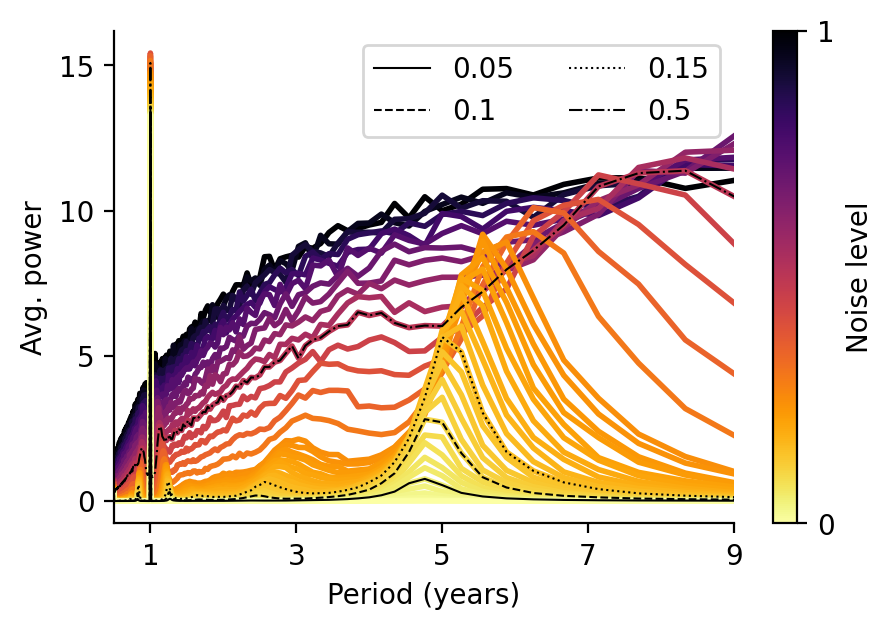

In [22]:
# 7) Plot Period vs. Power
import matplotlib.cm as cm
import matplotlib as mpl

fig = plt.figure(figsize=(5, 3.2), dpi=200)
ax = plt.gca()

for i in range(len(noise_levels)):
    i = len(noise_levels)-i-1
    #print(i)
    plt.plot(periods, power_curves[i],
             color=plt.cm.inferno(1-noise_levels[i]/np.max(noise_levels)),
             #label=f"FFT, noise={np.round(noise_levels[i],4)}",
            linewidth=2)


plt.xlim([0.5, 9])

i = 5
plt.plot(periods, power_curves[i], "-",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 10
plt.plot(periods, power_curves[i], "--",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 15
plt.plot(periods, power_curves[i], ":",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 30
plt.plot(periods, power_curves[i], "-.",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

#plt.gca().invert_xaxis()  # put shorter periods on the right
plt.xlabel("Period (years)")
plt.ylabel("Avg. power")
#plt.title("FFT-based Power Spectrum")
plt.xticks([1, 3, 5, 7, 9])
plt.legend(ncol=2)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap='inferno_r'),
             ax=ax, orientation='vertical', label='Noise level', ticks=[0,1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([0, 5, 10, 15])

In [24]:
# Empirical fourier:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import re
from datetime import datetime
from isoweek import Week

# Load the dataset (adjust the file path to your own setup)
#file_path = 'myco_allseasons_w52merge.csv'
#data = pd.read_csv(file_path)
#data = pd.read_csv("/home/bjarke/pCloudDrive/PhD/Princeton/Mycoplasma/posfrac_pseudofrac_with_infprox.csv", dtype=str)
data = pd.read_csv("/home/bjarke/pCloudDrive/PhD/Princeton/Mycoplasma/DKData/DK_2010_2025_posfrac.csv", dtype=str)

# Fill any missing values in the 'Nb_PositiveCases' column
#inc_proxy = data['Nb_PositiveCases'].fillna(0).values

# Compute a date column:
# Helper function to parse ISO week format (e.g. "2020-W12") into a date (Monday of that ISO week)
def iso_week_to_date(iso_str):
    """
    Convert 'YYYY-Www' string into a Python date.
    Example: "2020-W12" -> Monday of the 12th ISO week of 2020.
    """
    match = re.match(r"(\d{4})-W(\d{1,2})", iso_str)
    if not match:
        return None
    year, week = match.groups()
    year, week = int(year), int(week)
    return Week(year, week).monday()

# Create a 'date' column from 'year_Week'
data["date"] = data["year_Week"].apply(iso_week_to_date)

data['date'] = pd.to_datetime(data["date"])

# Look only a pre-COVID times:
data = data[data["date"] < np.datetime64(iso_week_to_date("2020-W12"))]

inc_proxy = data['PosFrac'].fillna(0).values

inc_proxy = np.float64(inc_proxy)

In [25]:
from astropy.timeseries import LombScargle

# 1) (Optional) Remove any mean (DC offset) so that the FFT isn't dominated by zero freq
#I_demeaned = I - np.mean(I)
# Or don't:
I = inc_proxy
I_demeaned = I
t_loc = np.arange(len(I_demeaned))/52

# 2) We'll do an FFT. First compute the sampling interval dt in years.
dt = t_loc[1] - t_loc[0]  # in years
n = len(I_demeaned)

# 3) Compute the Discrete Fourier Transform
#    np.fft.rfft gives the one-sided spectrum (0 ... Nyquist freq)
fhat = np.fft.rfft(I_demeaned)        # Complex DFT coefficients
power = np.abs(fhat)**2               # Power is magnitude squared

# 4) Associated frequencies (one-sided)
freqs = np.fft.rfftfreq(n, d=dt)      # in cycles/year

# 5) Convert freq to period in years, ignoring zero frequency (freq[0] = 0)
#    to avoid division by zero, we can skip the freq=0 component
freqs_nonzero = freqs[1:]      # from index 1 to end
power_nonzero_loc = power[1:]
periods_emp = 1.0 / freqs_nonzero  # in years

# 6) (Optionally) limit the range to 0.5–10 years, just as in Lomb–Scargle
mask = (periods_emp >= 0.5) & (periods_emp <= 11)
periods_emp = periods_emp[mask]
eps_log = 0.001
power_nonzero = power_nonzero_loc[mask]/n

# 1. Specify the frequency range. 
#    If you want to see periods from, say, half a year (0.5 yr) to 10 years,
#    that translates to frequencies from 1/10 to 2 cycles/year.
min_freq = 1.0 / 10.0  # 1/10 = 0.1 cyc/yr
max_freq = 1/0.4         # 2 cyc/yr = 0.5-year period

# 2. Create a LombScargle object:
ls = LombScargle(t_loc, I)

# 3. Evaluate the periodogram over that frequency range:
frequency, power_loc = ls.autopower(
    minimum_frequency=min_freq,
    maximum_frequency=max_freq,
    samples_per_peak=50,  # oversampling factor, can adjust for resolution
    normalization='psd'
)

# 4. Convert frequency to period, if you prefer seeing period on the x-axis.
period_ls = 1/frequency
power_ls = power_loc

Peak LS: 4.916067146282973
Peak Fourier: 5.134615384615385


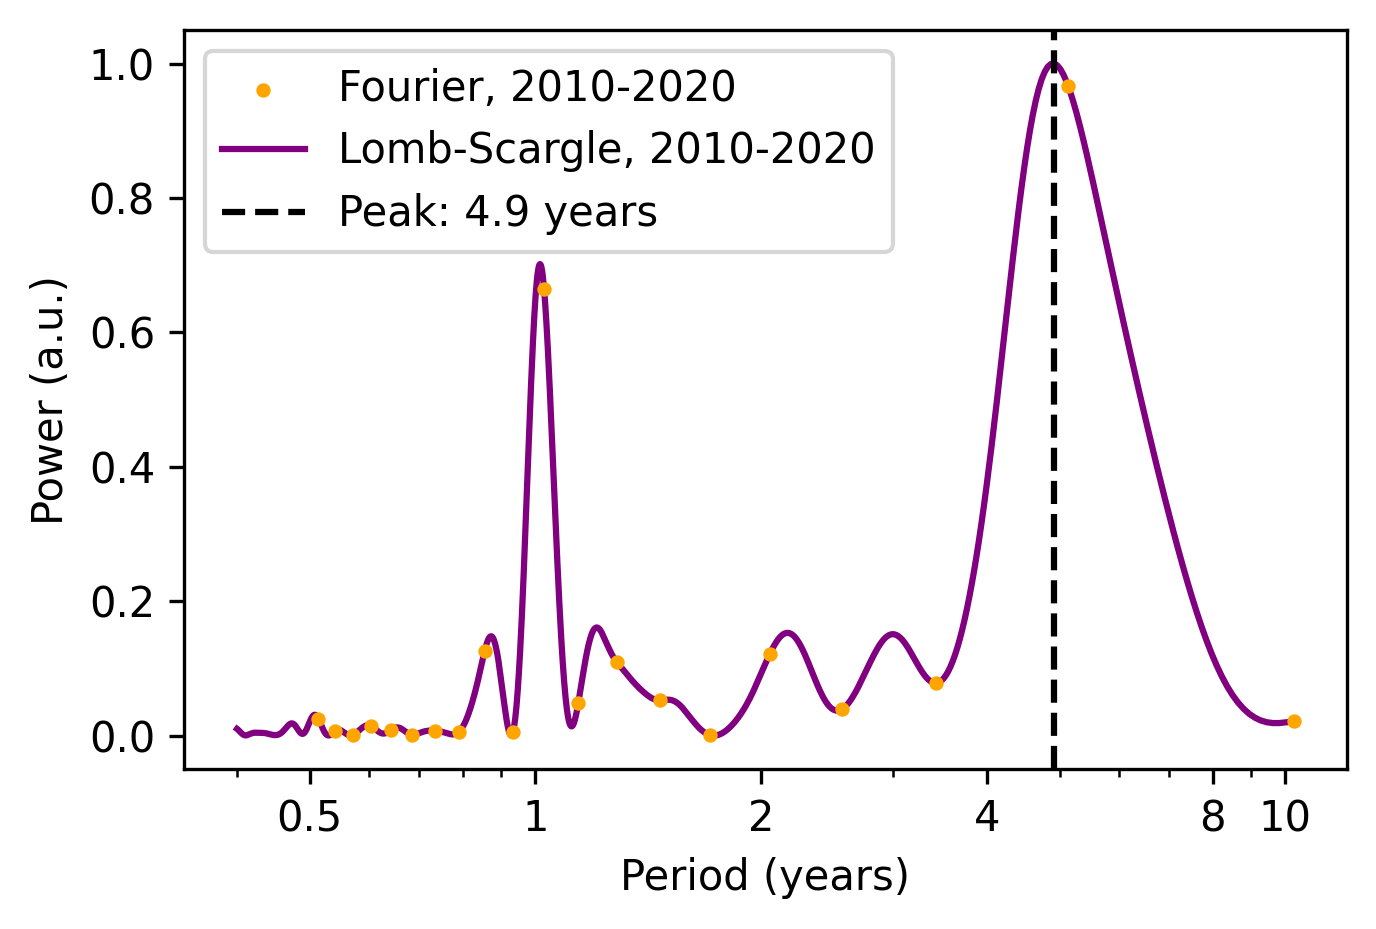

In [26]:
plt.figure(figsize=(5, 3.2), dpi=300)

periods_emp = periods_emp[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.scatter(periods_emp, power_nonzero, label="Fourier, 2010-2020", s=6, color=color1, zorder=2)
plt.plot(period_ls, power_ls, label="Lomb-Scargle, 2010-2020", color=color2, zorder=1)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("Peak LS:", dominant_period)
plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods_emp > 1.5])
dominant_period = periods_emp[periods_emp > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)

Peak LS: 4.916067146282973
Peak Fourier: 5.134615384615385


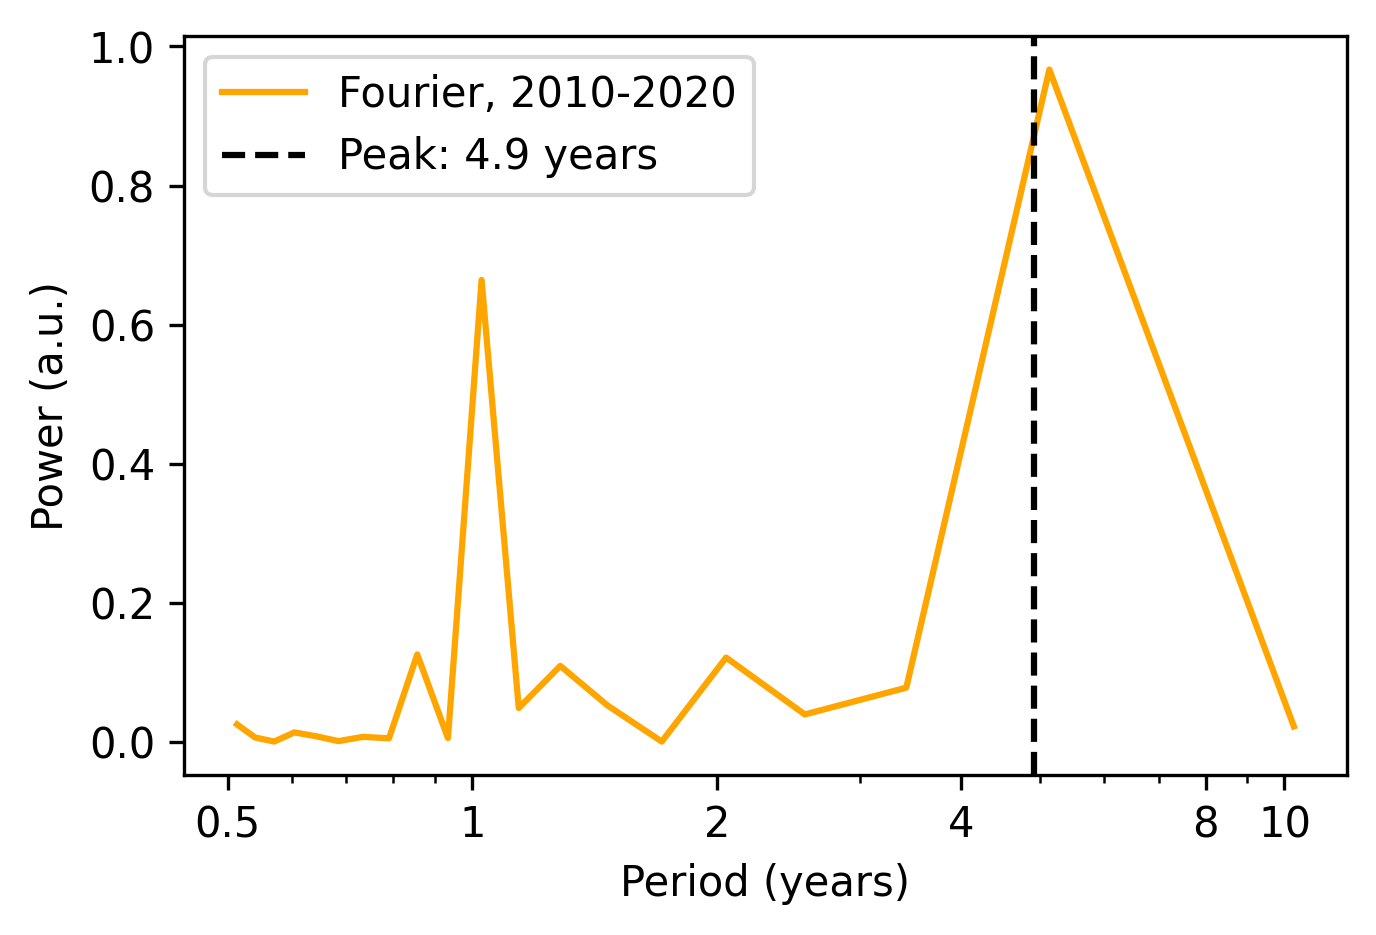

In [27]:
plt.figure(figsize=(5, 3.2), dpi=300)

periods_emp = periods_emp[::1]
power_nonzero = power_nonzero[::1]

factor = 1/np.max(power_ls[period_ls > 0.5])

power_nonzero *= factor
power_ls *= factor

color1 = "orange"
color2 = "purple"

plt.plot(periods_emp, power_nonzero, label="Fourier, 2010-2020", color=color1, zorder=2)

plt.xscale('log')
plt.xticks([0.5, 1, 2, 4, 8, 10], labels=[0.5, 1, 2, 4, 8, 10])

# Identify dominant multi-year peak
peak_idx = np.argmax(power_ls[period_ls > 1.5])
dominant_period = period_ls[period_ls > 1.5][peak_idx]
print("Peak LS:", dominant_period)
plt.axvline(dominant_period, color='black', linestyle='--', label=f"Peak: {dominant_period:.1f} years", linewidth=1.5)
plt.xlabel("Period (years)")
plt.ylabel("Power (a.u.)")
plt.legend()

peak_idx = np.argmax(power_nonzero[periods_emp > 1.5])
dominant_period = periods_emp[periods_emp > 1.5][peak_idx]
print("Peak Fourier:", dominant_period)

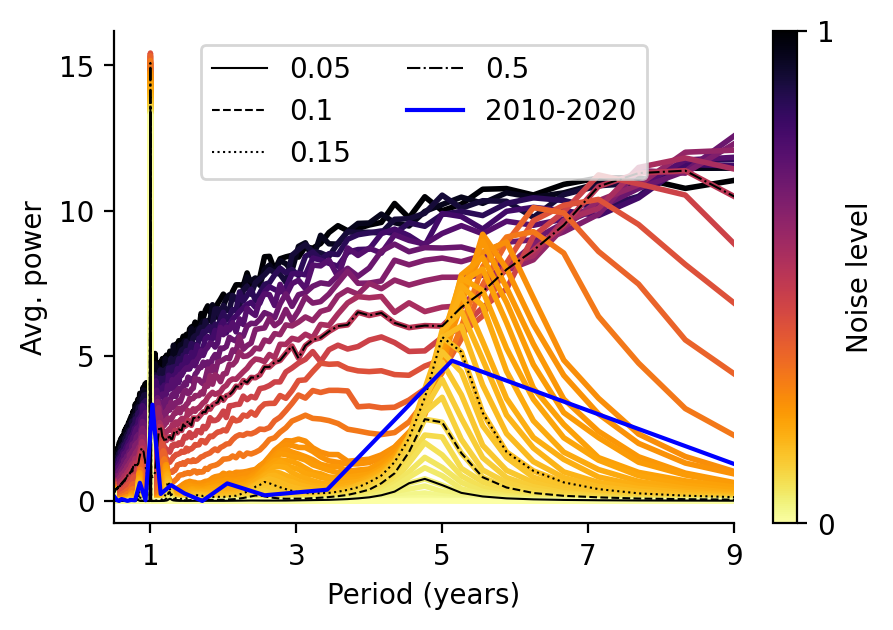

In [34]:
# 7) Plot Period vs. Power
import matplotlib.cm as cm
import matplotlib as mpl

fig = plt.figure(figsize=(5, 3.2), dpi=200)
ax = plt.gca()

for i in range(len(noise_levels)):
    i = len(noise_levels)-i-1
    #print(i)
    plt.plot(periods, power_curves[i],
             color=plt.cm.inferno(1-noise_levels[i]/np.max(noise_levels)),
             #label=f"FFT, noise={np.round(noise_levels[i],4)}",
            linewidth=2)


plt.xlim([0.5, 9])

i = 5
plt.plot(periods, power_curves[i], "-",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 10
plt.plot(periods, power_curves[i], "--",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 15
plt.plot(periods, power_curves[i], ":",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

i = 30
plt.plot(periods, power_curves[i], "-.",
             color="black",
             label=f"{np.round(noise_levels[i],4)}",
            linewidth=0.75)

#plt.gca().invert_xaxis()  # put shorter periods on the right
plt.xlabel("Period (years)")
plt.ylabel("Avg. power")
#plt.title("FFT-based Power Spectrum")
plt.xticks([1, 3, 5, 7, 9])

fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap='inferno_r'),
             ax=ax, orientation='vertical', label='Noise level', ticks=[0,1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks([0, 5, 10, 15])


plt.plot(periods_emp, power_nonzero*5, color="blue", zorder=2, label="2010-2020")
plt.legend(ncol=2)
#plt.plot(period_ls, power_ls*10, label="Lomb-Scargle, 2010-2020", color="cyan", zorder=2)